In [1]:
import geopandas
import pandas as pd
#import geoplot
import os
import descartes
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import pyproj
import Instaplot as IP
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure

In [2]:
%matplotlib inline

In [3]:
import shapely
from shapely.geometry import Point

(7.568091341946085, 7.783160707344514, 45.00010226823592, 45.14685831740915)

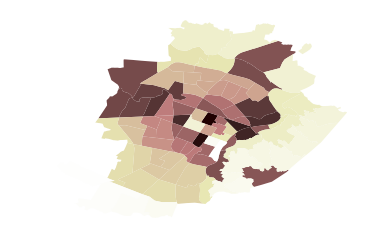

In [4]:
#The file we got from the TOrino website is in Gauss-Boaga projection. its EPSG code is 3003 but it does not know it.
df = geopandas.read_file('zone_statistiche_geo/zone_statistiche_geo.shp')
#We have to tell it:
df.crs={'init':'epsg:3003'}
#And then to plot it in the usual GPS coordinates.
df.to_crs(epsg=4326).plot(cmap='pink')#.to_crs({'proj': 'merc'}).plot()
plt.axis('off')

In [6]:
A=pkl.load(open('replot/tosend/A.pkl', "rb"))
Grid=pkl.load(open('PKL_files/results/NTF_2401_17/Grid.pkl', "rb"))

topic1=pd.DataFrame(index=Grid)
for i in [0,3]:
    data=list(A.T[i])
    Norm_factor=np.sqrt(sum([d**2 for d in data]))
    data=np.array([d/Norm_factor for d in data])
    data = np.ma.masked_where(data==0, data)
    topic1['data{}'.format(i)] = pd.Series(data, index=Grid)
    #topic1=pd.DataFrame({'data{}'.format(i):list(A.T[i])}, index=Grid)

#Our coordinates systems are transposed wrt what geopandas expect
Grid2=[(a[1],a[0]) for a in Grid]
#Encode points in a way that geopandas understands
points=pd.Series([Point(a) for a in Grid2],index=Grid)
topic1['points']=points
#Our coordinates are in the usual WGS84 encoding (i.e. EPSG: 4326).
TOP1 = geopandas.GeoDataFrame(topic1, geometry=points)
TOP1.crs = {'init': 'epsg:4326', 'no_defs': True}
#TOP1.plot()

In [7]:
import numpy as np
from scipy import ndimage
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

def heatmap_2(d, cmap, smoothing=1.3):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    dat=d[d.columns[0]].tolist()
    for i in xrange(len(dat)):
        if str(dat[i])=='nan':
            dat[i]=0
    Norm=np.sqrt(sum([d**2 for d in dat]))
    print Norm
    dat=[d/Norm for d in dat]
    absc=sorted(list(set(x)))
    ordo=sorted(list(set(y)))
    # Add the end of the last box
    ordo.append(2*ordo[-1]-ordo[-2])
    absc.append(2*absc[-1]-absc[-2])
    #Build a heatmap that shows the NODES and not the BOXES; we have one extra box for each coordinate.
    heatmap = np.zeros((len(absc)-1, len(ordo)-1))
    for i in xrange(len(x)):
        heatmap[ordo.index(y[i]),absc.index(x[i])]=dat[i]
    extent = [min(absc), max(absc), max(ordo), min(ordo)]
    heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')   
    val = filters.threshold_otsu(heatmap)
    print val
    heatmap = np.ma.masked_where(heatmap<val, heatmap)
    cmap=plt.cm.jet
    cmap.set_bad(color='white')
    plt.imshow(heatmap, extent=extent,cmap=cmap,alpha=.5)
    plt.colorbar(shrink=.5)
    plt.gca().invert_yaxis()
    #plt.show()
    print (len(set(y)),len(set(x)))

8.58196154215e-06 0.528138178744
0.9999999999999999
0.04826033640630588
(31, 31)


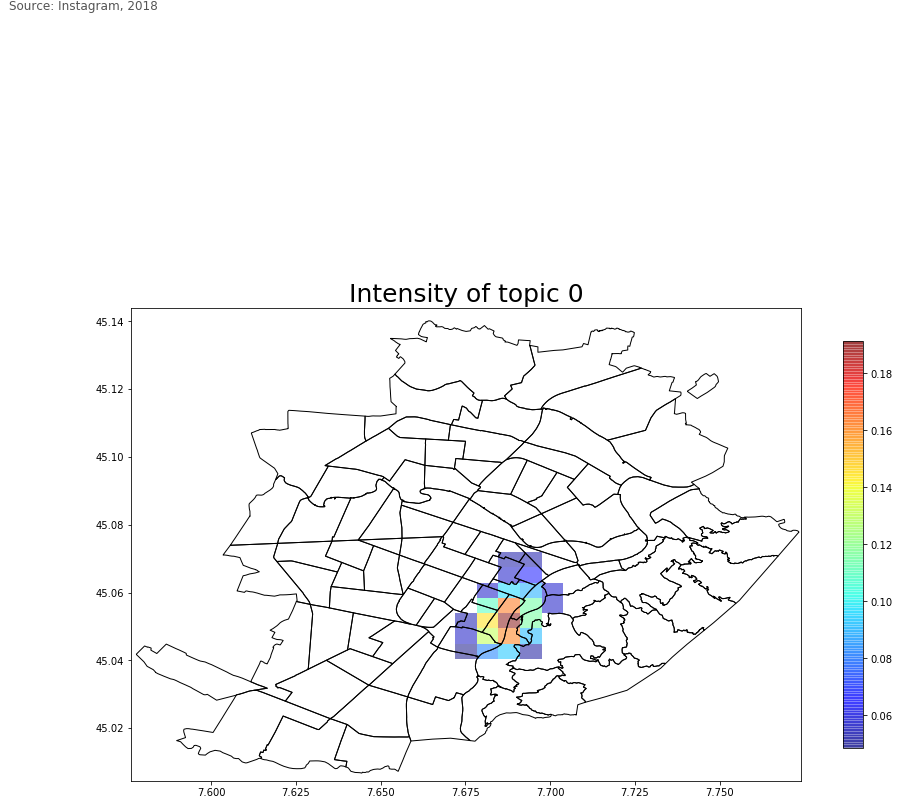

0.000145529465534 0.181814944442
0.9999999999999999
0.031960070906643004
(31, 31)


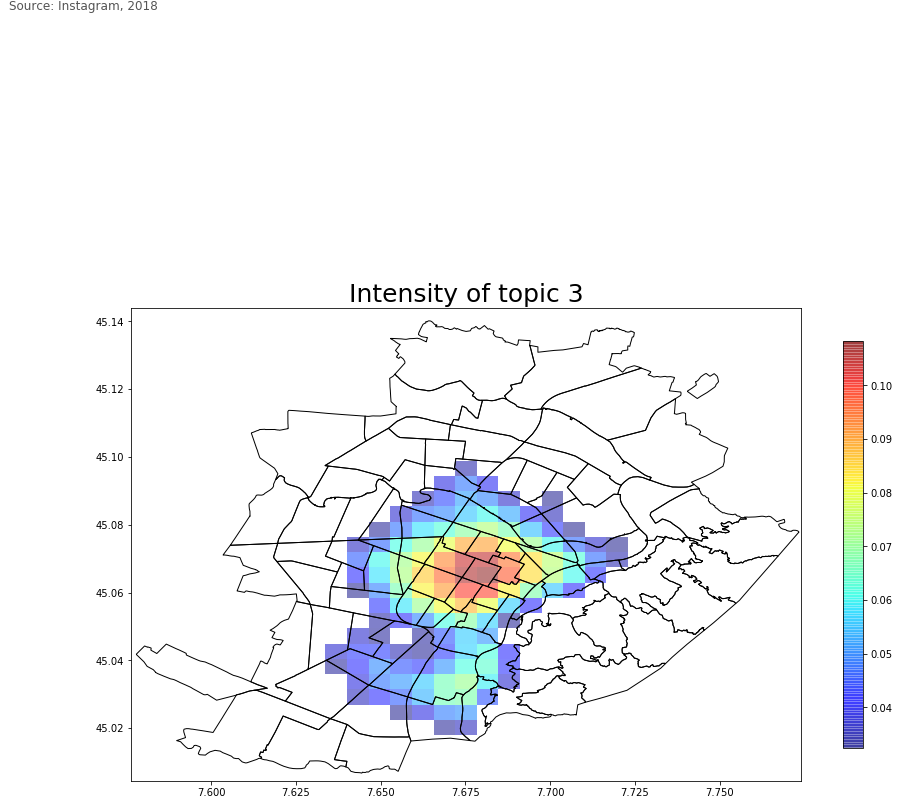

In [15]:
reload(IP)
colors='jet'
for i in [0,3]:
    TOP_list=[e for e in TOP1['data{}'.format(i)].tolist() if str(e) != 'nan']
    vmin, vmax= min(TOP_list),max(TOP_list)
    print vmin, vmax
    ax = df.to_crs(epsg=4326).plot(figsize=(15,15), linewidth=1, edgecolor='black', color=(0,0,0,0))
    heatmap_2(TOP1[['data{}'.format(i),'geometry']],colors, smoothing=1)
    #ax = TOP1.plot(figsize=(15,15),column='data{}'.format(i), markersize=100, marker='s', ax=ax, cmap=colors,vmin=vmin,vmax=vmax, alpha=.5)
    
    ax.axis='off'
    # add a title
    ax.set_title('Intensity of topic {}'.format(i), fontdict={'fontsize': '25', 'fontweight' : '3'})

    # create an annotation for the data source
    ax.annotate('Source: Instagram, 2018',xy=(0.01, 1),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []

    # add the colorbar to the figure
    #cbar = plt.colorbar(sm,shrink=.5)
    
    #IP.geo_hm_one_2(TOP1['data{}'.format(i)].tolist(),TOP1['geometry'].tolist(),colors,'try',ax=ax,save=False,folder='',shapefile='zone_statistiche_geo/zone_statistiche_geo.shp')
    plt.savefig('replot/topic_dots_{}.pdf'.format(i))
    plt.savefig('replot/topic_smoothed_otsu_{}.pdf'.format(i))
    
    plt.show()
    plt.close()

8.58196154215e-06 0.528138178744
otsu threshold 0.265588544358871


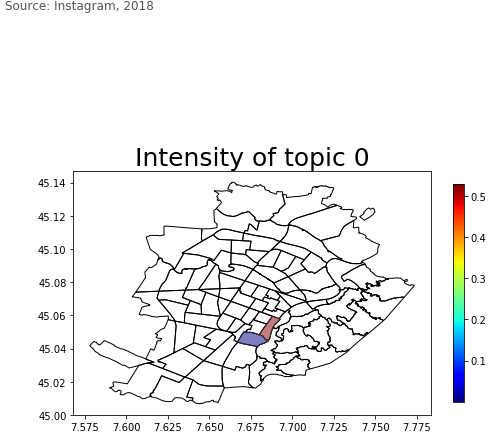

0.000145529465534 0.181814944442
otsu threshold 0.19425852471301452


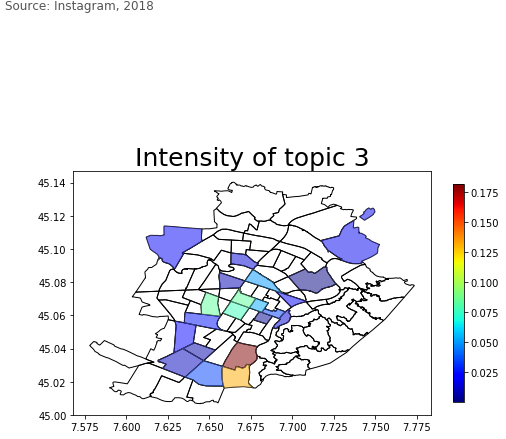

In [14]:
reload(IP)
colors='jet'
for i in [0,3]:
    TOP_list=[e for e in TOP1['data{}'.format(i)].tolist() if str(e) != 'nan']
    vmin, vmax= min(TOP_list),max(TOP_list)
    print vmin, vmax
    ax = df.to_crs(epsg=4326).plot(figsize=(8,8), linewidth=1, edgecolor='black', color=(0,0,0,0))
    #ax = TOP1.plot(figsize=(15,15),column='data{}'.format(i), markersize=100, ax=ax, cmap=colors,vmin=min(TOP1['data{}'.format(i)].tolist()),vmax=max(TOP1['data{}'.format(i)].tolist()), alpha=.5)
    IP.geo_hm_one_2(TOP1['data{}'.format(i)].tolist(),TOP1['geometry'].tolist(),colors,'try',ax=ax,save=False,folder='',shapefile='zone_statistiche_geo/zone_statistiche_geo.shp')

    ax.axis='off'
    # add a title
    ax.set_title('Intensity of topic {}'.format(i), fontdict={'fontsize': '25', 'fontweight' : '3'})

    # create an annotation for the data source
    ax.annotate('Source: Instagram, 2018',xy=(0.01, 1),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # empty array for the data range
    sm._A = []

    # add the colorbar to the figure
    cbar = plt.colorbar(sm,shrink=.5)
    #plt.savefig('replot/topic_ngh_otsu_{}.pdf'.format(i))
    plt.show()
    plt.close()

In [109]:
TOP1.head()

,data0,data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15,data16,points,geometry
"(45.0045, 7.60194240037)",NaN,NaN,NaN,0.001382,NaN,0.000612,NaN,NaN,NaN,0.011549,NaN,0.018626,0.000248,NaN,NaN,NaN,0.000318,POINT (7.601942400366751 45.00449999999999),POINT (7.601942400366751 45.00449999999999)
"(45.0045, 7.62105876852)",0.005881,NaN,NaN,0.002002,NaN,NaN,NaN,NaN,NaN,0.048948,0.006053,0.034050,0.001761,NaN,NaN,NaN,NaN,POINT (7.6210587685152 45.00449999999999),POINT (7.6210587685152 45.00449999999999)
"(45.0045, 7.64654725938)",NaN,0.000903,NaN,NaN,0.000187,0.000030,NaN,0.000653,NaN,NaN,0.001368,0.000082,0.000445,NaN,0.000158,NaN,0.000971,POINT (7.646547259379799 45.00449999999999),POINT (7.646547259379799 45.00449999999999)
"(45.0045, 7.6529193821)",0.009778,NaN,NaN,NaN,NaN,0.000546,0.002204,NaN,NaN,NaN,NaN,0.060748,0.001430,NaN,0.021767,NaN,NaN,POINT (7.652919382095949 45.00449999999999),POINT (7.652919382095949 45.00449999999999)
"(45.0045, 7.65929150481)",NaN,NaN,NaN,0.000496,NaN,0.003171,0.003028,NaN,NaN,NaN,NaN,0.007185,0.001602,NaN,0.000174,NaN,NaN,POINT (7.659291504812099 45.00449999999999),POINT (7.659291504812099 45.00449999999999)


In [137]:
str(type(TOP1['geometry'].tolist()[0]))=='shapely.geometry.point.Point'

False

In [143]:
A=pkl.load(open('PKL_files/results/NTF_2401_17/A.pkl', "rb"))
Grid=pkl.load(open('PKL_files/results/NTF_2401_17/Grid.pkl', "rb"))

os.mkdir('trial_geo/')

In [11]:
import Instaplot as IP

In [17]:
os.listdir('.')

['Lagrange_Progetto',
 'Instalib.py',
 '.git',
 'ncp.py',
 'boom.pdf',
 'carta_sintesi_geo',
 'trial_geoboom.pdf',
 'matlab_export',
 'Instaplot.pyc',
 'TorInstagram_Git.ipynb',
 'questions_words.txt',
 'Untitled.ipynb',
 'Results',
 'Figures',
 'models',
 'PKL_files',
 'Instalib.pyc',
 'ncp.pyc',
 'posts_per_month',
 'trial_geo',
 'Instaplot.py',
 'Torino_data',
 '.ipynb_checkpoints',
 'Marseille_data',
 'Word2Vec_Instagram.ipynb',
 'Plotter.ipynb']

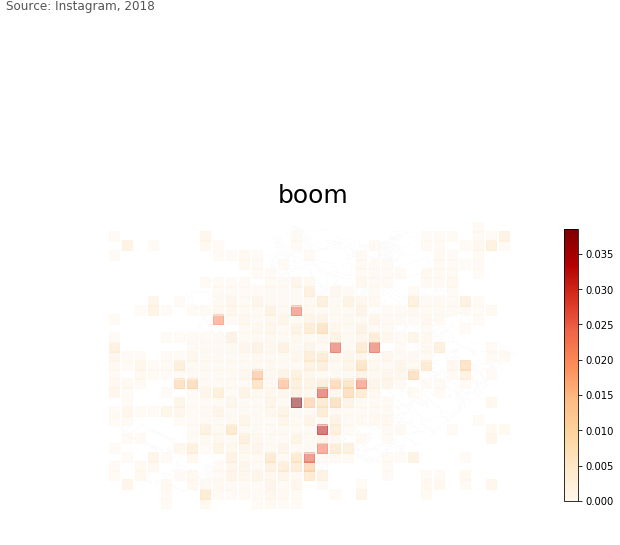

file saved trial_geo/boom


In [20]:
reload(IP)
IP.geo_plot_one(A.T[0],Grid,'OrRd','boom',save=True,folder='trial_geo/')

In [111]:
import numpy as np
from scipy import ndimage
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

def heatmap(d, smoothing=1.3, cmap='RdPu'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    print len(set(x)), len(set(y))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=(len(set(x))-1, len(set(y))-1))
    print heatmap.shape
    extent = [min(yedges), max(yedges), max(xedges), min(xedges)]
    print extent
    heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')
    
    plt.imshow(heatmap, extent=extent, cmap=cmap,alpha=.5)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    print (len(set(y)),len(set(x)))

In [72]:
A=np.zeros((3, 3))

In [75]:
A[2,2]=1
print A

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


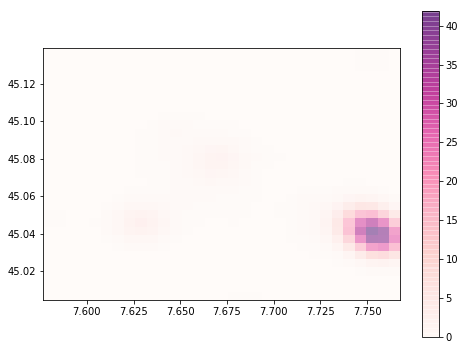

(31, 31)


In [82]:
heatmap_2(TOP1[['data16','geometry']], smoothing=1.5)

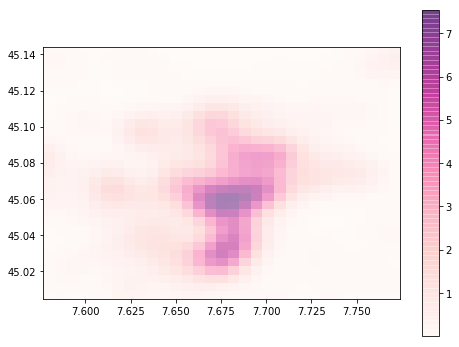

(31, 31)
[0.00010064914701929075, 0.008836932539914098, 0.0007407317080512625, 0.0]


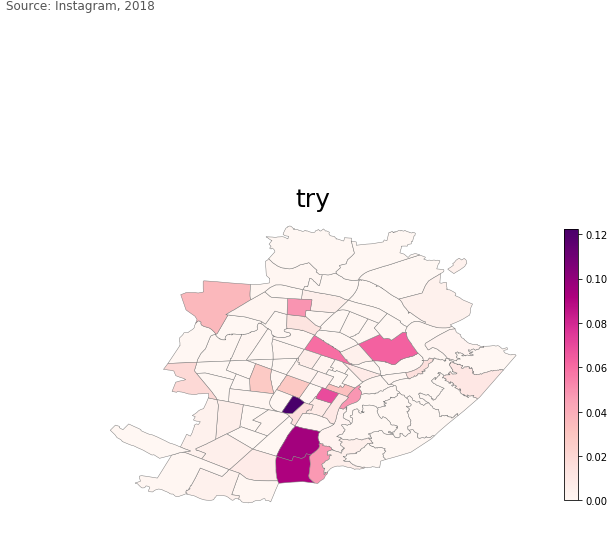

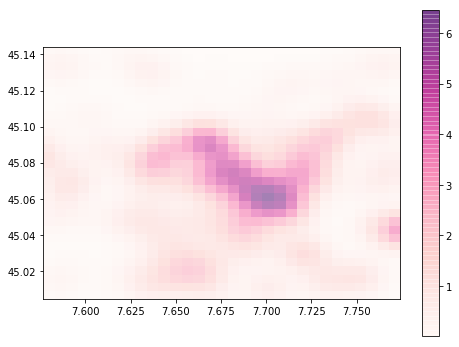

(31, 31)
[0.008379615174173674, 0.006590825698176048, 0.0, 0.00013944381746029244]


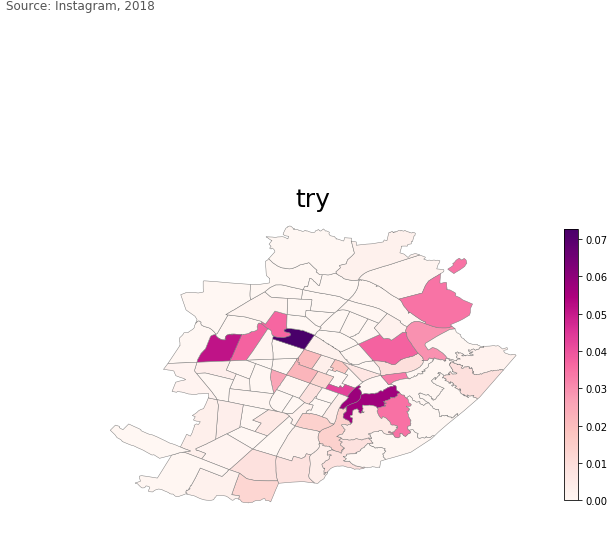

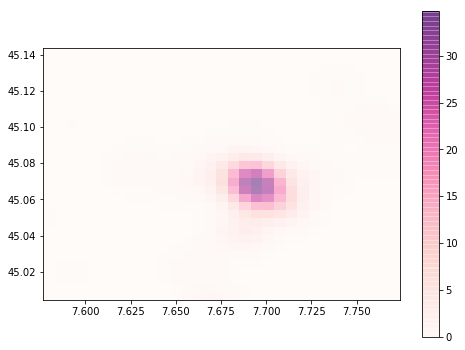

(31, 31)
[4.383603152109521e-06, 0.00221549038271525, 0.0, 8.050802494927832e-06]


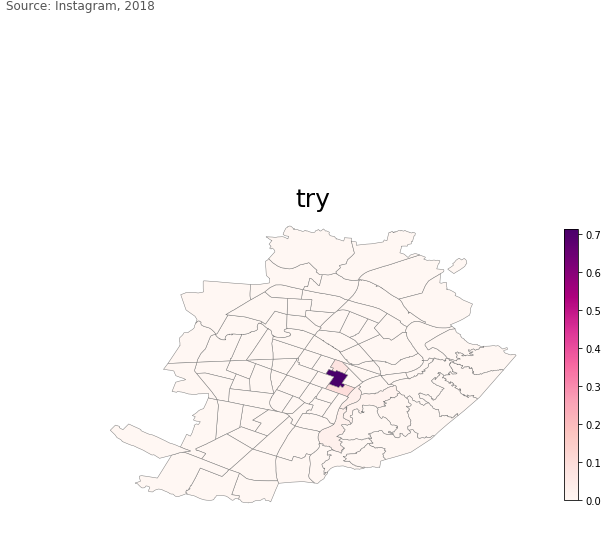

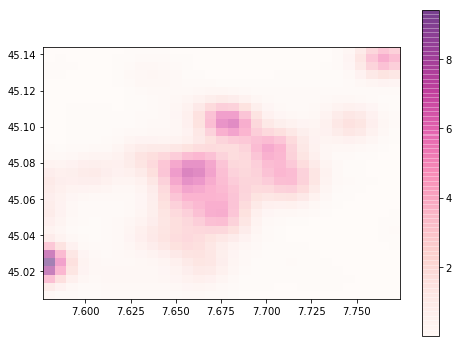

(31, 31)


KeyboardInterrupt: 

In [156]:
reload(IP)
colors='RdPu'
for i in xrange(5):
    vmin, vmax= min(TOP1['data{}'.format(i)].tolist()),max(TOP1['data{}'.format(i)].tolist())
    heatmap_2(TOP1[['data{}'.format(i),'geometry']], smoothing=1.5)
    IP.geo_hm_one(TOP1['data{}'.format(i)].tolist(),TOP1['geometry'].tolist(),colors,'try',save=False,folder='',shapefile='zone_statistiche_geo/zone_statistiche_geo.shp')
    
    plt.show()
    plt.close()